# Homework 7
Author: Mao Nishino

Download the image horse025b.png from Canvas, containing an image of a horse shape of size 84 ×128 pixels. The goal of this project is to train a regression Neural Network to predict the value
of a pixel $I(x, y)$ given its coordinates $(x, y)$. We will use the square loss functions on
the training examples $(x_i, y_i, I(x_i, y_i)), i = 1, \cdots , n$:
$\begin{equation} S(\bf{w})= \frac{1}{n}\sum_{i=1}^{n}(I(x_i-y_i)-f_{\textbf{w}}(x_i,y_i))^2\end{equation}$
where $(x_i, y_i) \in \{1, \cdots , 84\}\times \{1, \cdots , 128\}$ are all $n = 128 \cdot 84 = 10752$ pixels of the
image.
All NNs $f_w(x, y)$ we will train have a 2D input (x, y) and a 1D output, but we will
experiment with different numbers of hidden layers.
Try to use a GPU and CUDA for faster training. If you want, for better convergence,
you could try to standardize the inputs $(x_i, y_i)$ to have zero means and std 1, and the
outputs to have zero mean.

In [12]:
# Import Relevant Libraries
from PIL import Image
import torch
import torchvision
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Determine the device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"The calculation was done using {device}")

The calculation was done using cpu


In [23]:
EPOCHS = 300
BATCHSIZE = 64
LEARN_RATE = 0.003

class NeuralNetwork(torch.nn.Module):
    def __init__(self,
                 hidden_layers: torch.nn.Sequential):
        super().__init__()
        self.hidden_layers = hidden_layers

    def forward(self, x):
        x = self.hidden_layers(x)
        return x
    
class HW7():
    """ The class that achieves everything needed for the HW
    """
    def __init__(self,
                 hidden_layers: torch.nn.Sequential,
                 isdisplay = True):
        """
        Args:
            hidden_layers: Hidden layers used in training
            display: if True, outputs training progress
        """
        self.isdisplay = isdisplay

        # Data Preprocessing - Horse Image
        horse_image = Image.open("./horse025b.png").convert("L")
        to_tensor = torchvision.transforms.ToTensor()
        horse_tensor = to_tensor(horse_image)
        flat_horse = horse_tensor.flatten()
        horse_scaler = StandardScaler(with_std = False)
        std_flat_horse = horse_scaler.fit_transform(flat_horse.reshape(-1,1))
        std_flat_horse = torch.tensor(std_flat_horse).squeeze().float().to(device)
        assert not std_flat_horse.isnan().any()

        # Data Preprocessing - Coordinates
        height, width = horse_tensor.squeeze().shape
        coordinates = torch.tensor([(x,y) for x in range(width) for y in range(height)])
        coordinate_scaler = StandardScaler()
        std_coordinates = coordinate_scaler.fit_transform(coordinates)
        std_coordinates = torch.tensor(std_coordinates).float().to(device)
        assert not std_coordinates.isnan().any()

        # Couple the input-output pair
        coordinate_horse = list(zip(std_coordinates, std_flat_horse))
        self.data_loader = torch.utils.data.DataLoader(
            coordinate_horse,
            batch_size = BATCHSIZE
        )

        # Define Training Specifics
        self.neural_net = NeuralNetwork(hidden_layers).to(device)
        self.optimizer = torch.optim.SGD(self.neural_net.parameters(),
                                         lr = LEARN_RATE)
        self.loss_fn = torch.nn.MSELoss()
        self.scheduler = torch.torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size = 100,
            gamma = 0.5
        )
        self.losses = []
        
        # Training loop
        
        for epoch in range(EPOCHS):
            if isdisplay:
                print(f"----- Epoch {epoch+1} -----")
            self.losses.append(self.train_loop())
            self.scheduler.step()
        if isdisplay: print('Training Done')

        # Reconstruct Image
        with torch.no_grad():
            std_intensities = self.neural_net(std_coordinates)
            intensities =  (horse_scaler.inverse_transform(std_intensities)*255).astype(np.uint8)
            reconstructed_horse = Image.fromarray(intensities.reshape(height, width))

        # Show plots and images
        display(Markdown('The following plot shows the epochs vs the training loss.'))
        plt.figure(figsize = (10,6))
        plt.plot(range(1,EPOCHS+1), self.losses, marker = 'o',label = 'Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epochs vs Training Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        display(Markdown('The following is the reconstructed image.'))
        reconstructed_horse.show()

    def train_loop(self):
        """ One epoch in the training
        """
        data_size = len(self.data_loader.dataset)
        self.neural_net.train() # Not needed, but for best practice
        for batch, (X,y) in enumerate(self.data_loader):

            # Compute predicteion and loss (Forward pass)
            if torch.isnan(X).any():
                raise ValueError("NaN values found in inputs!")
            pred = self.neural_net(X).squeeze() # invokes 'foward' method
            if torch.isnan(pred).any():
                raise ValueError("NaN values found in predictions!")
            loss = self.loss_fn(pred, y)
            if torch.isnan(loss).any():
                raise ValueError("NaN values found in loss!")

            # Backpropagation
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.neural_net.parameters(), max_norm=100.)
            self.optimizer.step()
            # Ensure we don't accumulate the gradient
            self.optimizer.zero_grad()

            if batch % 50 == 0 and self.isdisplay:
                lossvalue, current = loss.item(), (batch+1)*len(X)
                print(f"loss: {lossvalue:>2f} [{current}][{data_size}]")
        return loss.item()

# Problem (a)
Train a NN with one hidden layer containing 128 neurons, followed by ReLU.
Train the NN for 300 epochs using the square loss (1). Use the SGD optimizer
with minibatch size 64, and an appropriate learning rate (e.g. 0.003). Reduce the
learning rate to half every 100 epochs. Show a plot of the loss function vs epoch
number. Display the image reconstructed from the trained NN fw(i, j), i ∈
{1, ..., 84}, j ∈{1, ..., 128}. (2 points)

The following plot shows the epochs vs the training loss.

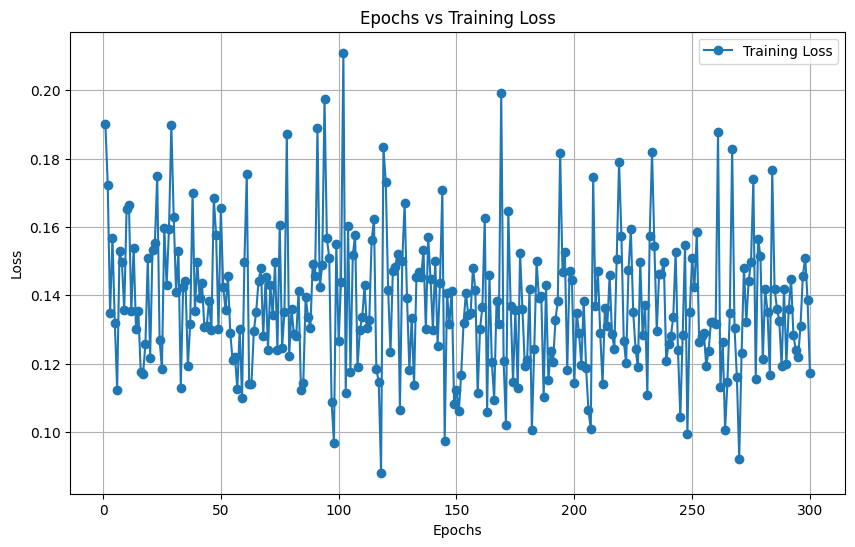

The following is the reconstructed image.

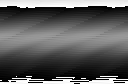

In [24]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)

torch.autograd.set_detect_anomaly(True)
hw = HW7(hidden_layers, isdisplay=False)

# Problem (b)
Repeat point a) with a NN with two hidden layers, first one with 32 neurons and
second one with 128 neurons, each followed by ReLU. (2 points)

The following plot shows the epochs vs the training loss.

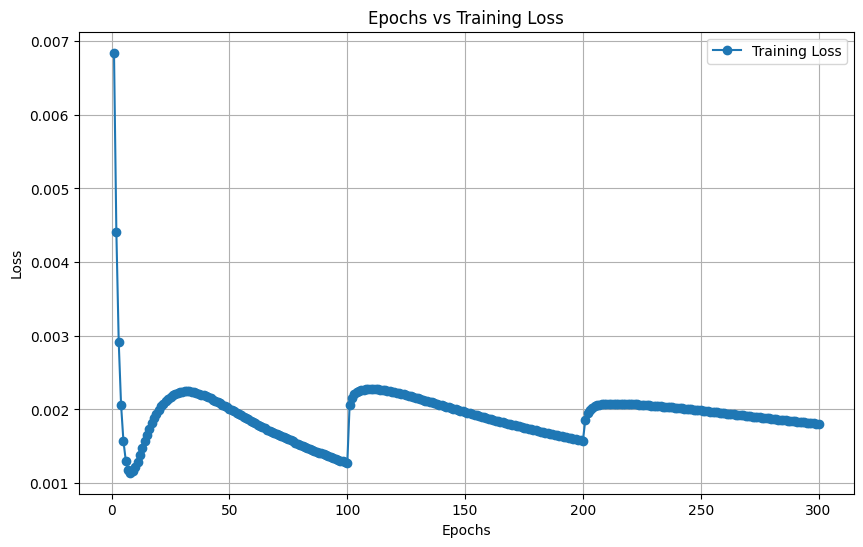

The following is the reconstructed image.

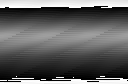

In [20]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)

torch.autograd.set_detect_anomaly(True)
hw = HW7(hidden_layers, isdisplay=False)

# Problem (c)
Repeat point a) with a NN with three hidden layers, with 32, 64 and 128 neurons
respectively, each followed by ReLU. (2 points)

The following plot shows the epochs vs the training loss.

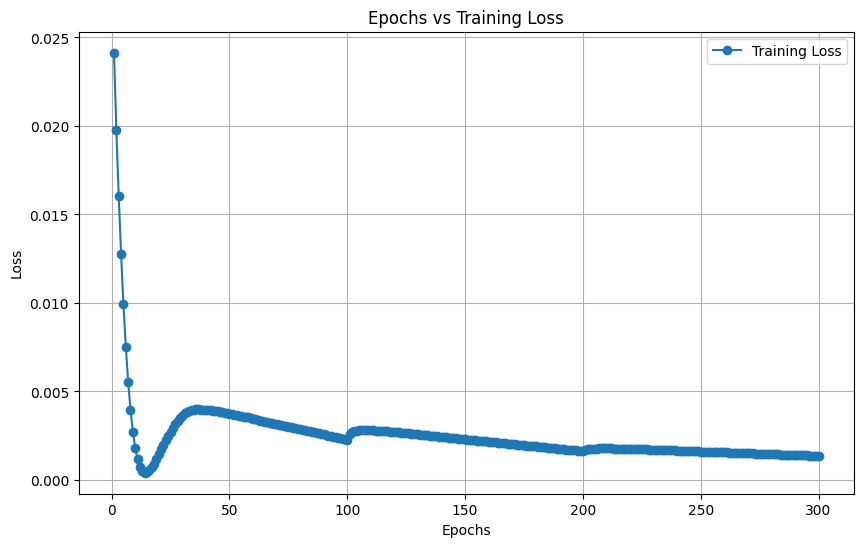

The following is the reconstructed image.

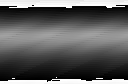

In [21]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)

torch.autograd.set_detect_anomaly(True)
hw = HW7(hidden_layers, isdisplay=False)

# Problem (d)
 Repeat point a) with a NN with four hidden layers, with 32, 64, 128 and 128
neurons respectively, each followed by ReLU. (3 points)

The following plot shows the epochs vs the training loss.

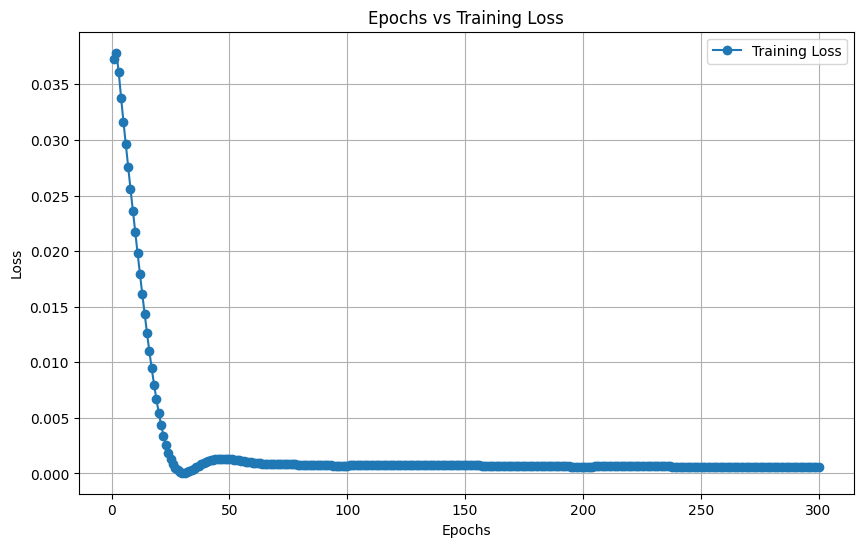

The following is the reconstructed image.

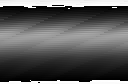

In [22]:
hidden_layers = torch.nn.Sequential(
    torch.nn.Linear(2,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,1)
)

torch.autograd.set_detect_anomaly(True)
hw = HW7(hidden_layers, isdisplay=False)

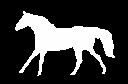

In [29]:
horse_image = Image.open("./horse025b.png").convert("L")
to_tensor = torchvision.transforms.ToTensor()
horse_tensor = to_tensor(horse_image)
height, width = horse_tensor.squeeze().shape
flat_horse = horse_tensor.flatten()
horse_scaler = StandardScaler(with_std = False)
std_flat_horse = horse_scaler.fit_transform(flat_horse.reshape(-1,1))
std_flat_horse = torch.tensor(std_flat_horse).squeeze().float().to(device)
intensities =  (horse_scaler.inverse_transform(std_flat_horse.reshape(-1,1))*255).astype(np.uint8)
reconstructed_horse = Image.fromarray(intensities.reshape(height, width))

reconstructed_horse.show()